# 5.0 Machine Learning
We will train several models on the data, using cross-validation to pick the best hyperparameters, and select the most promising model. The model will finally be evaulated on the test set.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_columns', 200)

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error, make_scorer
   
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
np.random.seed(101)

### Read in the data

In [4]:
DATA_FOLDER = os.path.join('data', 'final')

In [5]:
zoopla_df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'zoopla_train.csv'), dtype=str)
zoopla_df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'zoopla_test.csv'), dtype=str)

In [6]:
zoopla_df_train.columns

Index(['TOTAL_FLOOR_AREA_median', 'diff_published_date', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6',
       'cluster_7', 'num_bedrooms', 'num_bathrooms',
       'CURRENT_ENERGY_RATING_mode', 'POTENTIAL_ENERGY_RATING_mode',
       'CONSTRUCTION_AGE_BAND_mode', 'Index of Multiple Deprivation Decile',
       'Income Decile', 'Employment Decile', 'Education and Skills Decile',
       'Health and Disability Decile', 'Crime Decile',
       'Barriers to Housing and Services Decile', 'Living Environment Decile',
       'IDACI Decile', 'IDAOPI Decile', 'last_published_year',
       'last_published_month', 'first_published_year', 'first_published_month',
       'post_town_Nuneaton', 'parish_Hinckley and Bosworth, unparished area',
       'parish_Nuneaton and Bedworth, unparished area', 'parish_Other',
       'parish_Stoke Golding', 'postcode_CV10 7', 'postcode_CV10 8',
       'postcode_CV10 9', 'postcode_CV11 4', 'postcode_CV11 5',
       'postcode_CV11 6

In [7]:
X_train = zoopla_df_train.drop('LOG_price', axis=1).astype(float)
y_train = zoopla_df_train['LOG_price'].astype(float)

X_test = zoopla_df_test.drop('LOG_price', axis=1).astype(float)
y_test = zoopla_df_test['LOG_price'].astype(float)

Quick check of variables

In [8]:
X_train.head()

,TOTAL_FLOOR_AREA_median,diff_published_date,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,num_bedrooms,num_bathrooms,CURRENT_ENERGY_RATING_mode,POTENTIAL_ENERGY_RATING_mode,CONSTRUCTION_AGE_BAND_mode,Index of Multiple Deprivation Decile,Income Decile,Employment Decile,Education and Skills Decile,Health and Disability Decile,Crime Decile,Barriers to Housing and Services Decile,Living Environment Decile,IDACI Decile,IDAOPI Decile,last_published_year,last_published_month,first_published_year,first_published_month,post_town_Nuneaton,"parish_Hinckley and Bosworth, unparished area","parish_Nuneaton and Bedworth, unparished area",parish_Other,parish_Stoke Golding,postcode_CV10 7,postcode_CV10 8,postcode_CV10 9,postcode_CV11 4,postcode_CV11 5,postcode_CV11 6,postcode_CV11 7,postcode_CV12 9,postcode_CV13 0,postcode_CV13 6,postcode_CV9 3,postcode_LE10 0,postcode_LE10 1,postcode_LE10 2,postcode_LE10 3,postcode_LE9 7,PROB_4BAND_Medium,PROB_4BAND_None,property_type_general_Detached house,property_type_general_End terrace house,property_type_general_Flat,property_type_general_Maisonette,property_type_general_Other/Unknown,property_type_general_Semi-detached house,property_type_general_Terraced house
0,0.755945,-0.699124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.075124,0.825820,1.617842,1.700535,-0.534404,-1.164162,-1.237357,-1.544492,-1.481684,-0.244458,-0.112069,0.983099,1.030554,-0.777371,-0.589032,-1.544498,1.117375,-0.576376,0.502342,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.171376,-0.325847,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.010751,-0.480830,0.473837,-0.149598,0.088982,-0.028729,-0.093148,0.109151,-0.282351,-0.689328,0.706170,-0.248654,0.636538,-0.373352,1.017057,-1.544498,1.574432,-0.576376,0.745100,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.501176,0.047430,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.010751,-0.480830,0.473837,-0.149598,-0.534404,1.106703,1.051061,0.935973,1.316759,0.200412,0.706170,0.572515,-0.151495,1.646747,0.615535,0.647459,-0.710851,-0.576376,0.745100,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2.699468,0.047430,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.075124,0.825820,1.617842,1.700535,-1.157791,-0.407207,-0.474551,0.109151,-0.682129,-1.134197,-0.521189,1.393684,-0.939527,-0.373352,-0.589032,-1.544498,1.802960,-0.576376,0.502342,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.632287,0.793983,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.010751,-1.787481,-0.670168,-0.149598,0.088982,-0.785684,-0.855954,-0.717670,-0.682129,-0.689328,-1.339428,0.983099,-0.545511,-0.373352,-0.589032,0.647459,-0.482323,-0.576376,0.502342,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
for colname in X_train.columns:
    display(X_train[colname].value_counts(dropna=False))

-0.200393    100
 0.138953     13
-0.385490     13
-0.231242     12
-0.447189     12
            ... 
-0.432983      1
 0.345337      1
-0.458763      1
 2.282999      1
 0.773529      1
Name: TOTAL_FLOOR_AREA_median, Length: 207, dtype: int64

-0.699124    259
-0.325847     96
 0.047430     79
 0.420706     56
 0.793983     39
 1.167259     28
 1.913813     18
 1.540536     13
 2.660366      6
 3.033643      3
 3.406919      2
 3.780196      2
 5.273303      1
 4.526749      1
 9.379346      1
 6.019856      1
 2.287089      1
Name: diff_published_date, dtype: int64

0.0    526
1.0     80
Name: cluster_1, dtype: int64

0.0    536
1.0     70
Name: cluster_2, dtype: int64

0.0    480
1.0    126
Name: cluster_3, dtype: int64

0.0    500
1.0    106
Name: cluster_4, dtype: int64

0.0    554
1.0     52
Name: cluster_5, dtype: int64

0.0    603
1.0      3
Name: cluster_6, dtype: int64

0.0    533
1.0     73
Name: cluster_7, dtype: int64

-0.010751    277
 1.075124    147
-1.096626    140
 2.160999     18
-2.182501     15
-3.268376      6
 4.332749      2
 3.246874      1
Name: num_bedrooms, dtype: int64

-0.480830    335
 0.825820    174
-1.787481     50
 2.132471     42
 3.439122      5
Name: num_bathrooms, dtype: int64

 0.473837    348
-0.670168    110
-1.814173     98
 1.617842     45
 2.761848      5
Name: CURRENT_ENERGY_RATING_mode, dtype: int64

-0.149598    431
 1.700535    109
-1.999732     64
 3.550669      2
Name: POTENTIAL_ENERGY_RATING_mode, dtype: int64

-0.846097    228
 0.088982     61
-0.222711     54
-0.534404     47
 0.712368     41
 1.335754     32
 2.270833     32
 1.647447     29
 0.400675     24
 1.024061     24
-1.157791     22
 1.959140     12
Name: CONSTRUCTION_AGE_BAND_mode, dtype: int64

 0.728226    158
-0.028729     68
-0.785684     65
-1.164162     58
-0.407207     56
 1.106703     53
 1.485181     53
-1.921117     36
-1.542639     32
 0.349748     27
Name: Index of Multiple Deprivation Decile, dtype: int64

 1.051061    135
 0.288255    102
-0.474551     80
-0.855954     66
 1.432465     53
-1.237357     47
-1.618760     39
-0.093148     38
 0.669658     24
-2.000164     22
Name: Income Decile, dtype: int64

 0.109151    144
 0.935973     97
 1.349384     88
-0.717670     67
-1.131081     62
-1.544492     41
 0.522562     36
-0.304259     35
-1.957903     31
 1.762795      5
Name: Employment Decile, dtype: int64

-0.682129    119
 0.117426     94
-0.282351     85
 1.316759     82
-1.481684     62
-1.081906     54
 1.716537     48
 0.916982     31
 0.517204     25
 2.116314      6
Name: Education and Skills Decile, dtype: int64

 0.645281    116
-0.244458     87
-0.689328     83
 0.200412     78
-1.134197     65
 1.535020     56
 1.090151     44
-1.579067     44
-2.023936     17
 1.979890     16
Name: Health and Disability Decile, dtype: int64

-0.521189    132
 0.297051     87
 0.706170     86
-0.930308     62
 1.115290     48
-1.748548     45
 1.524410     45
-0.112069     38
-1.339428     37
 1.933529     26
Name: Crime Decile, dtype: int64

 0.572515    120
-1.069823     96
 0.983099     91
 0.161930     87
-1.480408     69
 1.393684     67
-0.659239     38
-0.248654     25
-2.301577     12
-1.890992      1
Name: Barriers to Housing and Services Decile, dtype: int64

-0.151495    122
 1.030554     95
-0.939527     86
 1.424570     84
 0.636538     53
-0.545511     51
-1.727559     48
 0.242521     33
-1.333543     29
-2.121575      5
Name: Living Environment Decile, dtype: int64

-0.373352    115
 1.242727     96
 0.838708     90
-0.777371     64
 0.030668     64
 0.434688     55
-1.989431     36
-1.585411     35
-1.181391     30
 1.646747     21
Name: IDACI Decile, dtype: int64

 1.017057    120
-0.589032     95
 0.615535     92
-0.187509     77
-0.990554     54
 1.418579     51
 0.214013     42
-1.793598     33
-2.195120     23
-1.392076     19
Name: IDAOPI Decile, dtype: int64

 0.647459    427
-1.544498    179
Name: last_published_year, dtype: int64

-0.710851    290
-0.482323    137
 1.574432     77
 1.802960     47
 1.345904     36
 1.117375     11
 0.888847      6
 0.431790      1
-0.253795      1
Name: last_published_month, dtype: int64

-0.576376    420
 1.490392    178
-2.643143      7
-4.709910      1
Name: first_published_year, dtype: int64

-1.439726    154
 0.745100     97
 0.987859     87
 0.502342     77
 1.230618     50
 0.259583     45
 0.016825     33
-1.196968     28
-0.225934     21
-0.954209      6
-0.711451      5
-0.468692      3
Name: first_published_month, dtype: int64

1.0    408
0.0    198
Name: post_town_Nuneaton, dtype: int64

0.0    417
1.0    189
Name: parish_Hinckley and Bosworth, unparished area, dtype: int64

1.0    394
0.0    212
Name: parish_Nuneaton and Bedworth, unparished area, dtype: int64

0.0    598
1.0      8
Name: parish_Other, dtype: int64

0.0    600
1.0      6
Name: parish_Stoke Golding, dtype: int64

0.0    564
1.0     42
Name: postcode_CV10 7, dtype: int64

0.0    561
1.0     45
Name: postcode_CV10 8, dtype: int64

0.0    534
1.0     72
Name: postcode_CV10 9, dtype: int64

0.0    561
1.0     45
Name: postcode_CV11 4, dtype: int64

0.0    582
1.0     24
Name: postcode_CV11 5, dtype: int64

0.0    514
1.0     92
Name: postcode_CV11 6, dtype: int64

0.0    592
1.0     14
Name: postcode_CV11 7, dtype: int64

0.0    605
1.0      1
Name: postcode_CV12 9, dtype: int64

0.0    603
1.0      3
Name: postcode_CV13 0, dtype: int64

0.0    597
1.0      9
Name: postcode_CV13 6, dtype: int64

0.0    605
1.0      1
Name: postcode_CV9 3, dtype: int64

0.0    485
1.0    121
Name: postcode_LE10 0, dtype: int64

0.0    542
1.0     64
Name: postcode_LE10 1, dtype: int64

0.0    599
1.0      7
Name: postcode_LE10 2, dtype: int64

0.0    600
1.0      6
Name: postcode_LE10 3, dtype: int64

0.0    605
1.0      1
Name: postcode_LE9 7, dtype: int64

0.0    601
1.0      5
Name: PROB_4BAND_Medium, dtype: int64

1.0    597
0.0      9
Name: PROB_4BAND_None, dtype: int64

0.0    406
1.0    200
Name: property_type_general_Detached house, dtype: int64

0.0    577
1.0     29
Name: property_type_general_End terrace house, dtype: int64

0.0    555
1.0     51
Name: property_type_general_Flat, dtype: int64

0.0    602
1.0      4
Name: property_type_general_Maisonette, dtype: int64

0.0    586
1.0     20
Name: property_type_general_Other/Unknown, dtype: int64

0.0    418
1.0    188
Name: property_type_general_Semi-detached house, dtype: int64

0.0    526
1.0     80
Name: property_type_general_Terraced house, dtype: int64

In [10]:
def predict_evaluate(model, X, y, actual_prices=False):
    
    """
    Predict a model on X and evaluate predictions vs actual values y for RMSE. Then plot RMSE vs y
    If actual_prices = True, then convert y values (which are logs) to raw values
    """
    
    y_preds = model.predict(X)
    label = 'LOG(Price)'
    
    if actual_prices:
        y = np.exp(y)
        y_preds = np.exp(y_preds)
        label = 'Price'
    
    print('RSME =', mean_squared_error(y, y_preds, squared=False))
    plt.plot(y, y_preds-y, 'b.')
    plt.xlabel(label)
    plt.ylabel('Predicted - Acual')
    plt.grid()
    

### Try fitting a simple linear regression model

RSME = 51631.59808937917


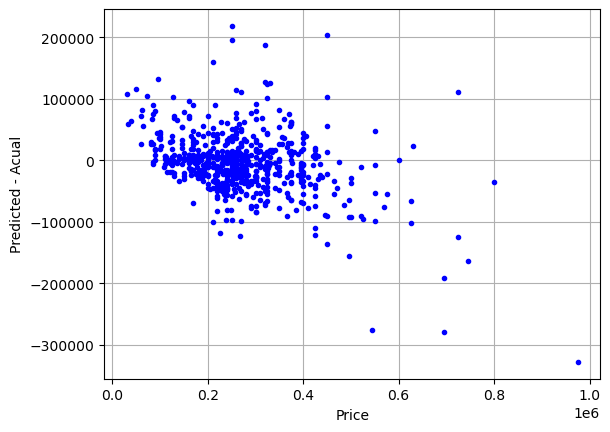

In [11]:
simple_lin_model = LinearRegression()
simple_lin_model.fit(X_train, y_train)

predict_evaluate(simple_lin_model, X_train, y_train, True)

### Try Ridge and Lasso Regression
We will try out different values of the hyperparameters using cross-validation

In [12]:
def RMSE(y_true, y_pred):
    
    """Make personalised scorer, in this case RMSE, for use in cross-validation"""
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE: %2.3f', rmse)
    return rmse

rmse = make_scorer(RMSE, greater_is_better=False)

Ridge regression

In [13]:
# Higher alpha = more regularisation
ridge_model_param_grid = {'alpha': [0, 0.001, 0.01, 0.1, 1, 2, 3, 5, 10], 'max_iter': [10000]}

# Scan all values of alpha and pick the one that optimises RMSE (from our scorer above)
grid_search_ridge_model = GridSearchCV(Ridge(random_state=101), ridge_model_param_grid, cv=5, verbose=3, scoring=rmse)
grid_search_ridge_model.fit(X_train, y_train)

print("Best value for alpha =", grid_search_ridge_model.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
RMSE: %2.3f 1441260827615.1843
[CV 1/5] END alpha=0, max_iter=10000;, score=-1441260827615.184 total time=   0.0s
RMSE: %2.3f 1318608102081.2808
[CV 2/5] END alpha=0, max_iter=10000;, score=-1318608102081.281 total time=   0.0s
RMSE: %2.3f 4948907622762.905
[CV 3/5] END alpha=0, max_iter=10000;, score=-4948907622762.905 total time=   0.0s
RMSE: %2.3f 0.21857636029739494
[CV 4/5] END ..........alpha=0, max_iter=10000;, score=-0.219 total time=   0.0s
RMSE: %2.3f 0.25639009741305235
[CV 5/5] END ..........alpha=0, max_iter=10000;, score=-0.256 total time=   0.0s
RMSE: %2.3f 0.27359580477948714
[CV 1/5] END ......alpha=0.001, max_iter=10000;, score=-0.274 total time=   0.0s
RMSE: %2.3f 0.2786667876237368
[CV 2/5] END ......alpha=0.001, max_iter=10000;, score=-0.279 total time=   0.0s
RMSE: %2.3f 0.26498530347226845
[CV 3/5] END ......alpha=0.001, max_iter=10000;, score=-0.265 total time=   0.0s
RMSE: %2.3f 0.21816380907625355
[CV

RSME = 51980.00354944546


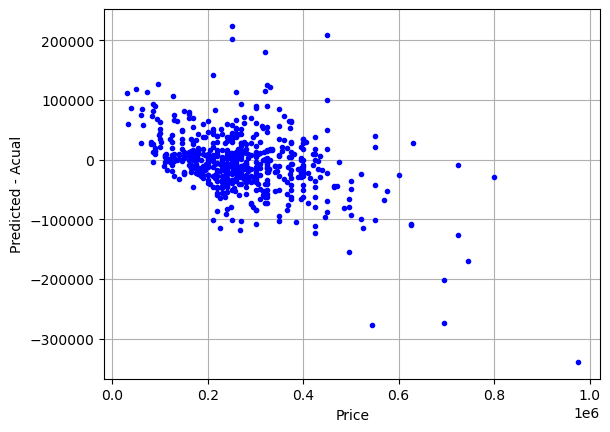

In [14]:
# pick best model and evaluate on training set for now
predict_evaluate(grid_search_ridge_model.best_estimator_, X_train, y_train, True)

Lasso regression

In [15]:
# Higher alpha = more regularisation
lasso_model_param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 5, 10], 'max_iter': [10000]}

grid_search_lasso_model = GridSearchCV(Lasso(random_state=101), lasso_model_param_grid, cv=5, verbose=3, scoring=rmse)
grid_search_lasso_model.fit(X_train, y_train)

print("Best value for alpha =", grid_search_lasso_model.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
RMSE: %2.3f 0.2702689060957142
[CV 1/5] END .....alpha=0.0001, max_iter=10000;, score=-0.270 total time=   0.1s
RMSE: %2.3f 0.27900957394532266
[CV 2/5] END .....alpha=0.0001, max_iter=10000;, score=-0.279 total time=   0.0s
RMSE: %2.3f 0.2589337764988308
[CV 3/5] END .....alpha=0.0001, max_iter=10000;, score=-0.259 total time=   0.1s
RMSE: %2.3f 0.21992679093078177
[CV 4/5] END .....alpha=0.0001, max_iter=10000;, score=-0.220 total time=   0.1s
RMSE: %2.3f 0.24545114057495654
[CV 5/5] END .....alpha=0.0001, max_iter=10000;, score=-0.245 total time=   0.1s
RMSE: %2.3f 0.25910404102017776
[CV 1/5] END ......alpha=0.001, max_iter=10000;, score=-0.259 total time=   0.0s
RMSE: %2.3f 0.27203843873010153
[CV 2/5] END ......alpha=0.001, max_iter=10000;, score=-0.272 total time=   0.0s
RMSE: %2.3f 0.2451639208191137
[CV 3/5] END ......alpha=0.001, max_iter=10000;, score=-0.245 total time=   0.0s
RMSE: %2.3f 0.23313109905368046
[CV 4/5

RSME = 53568.38429510664


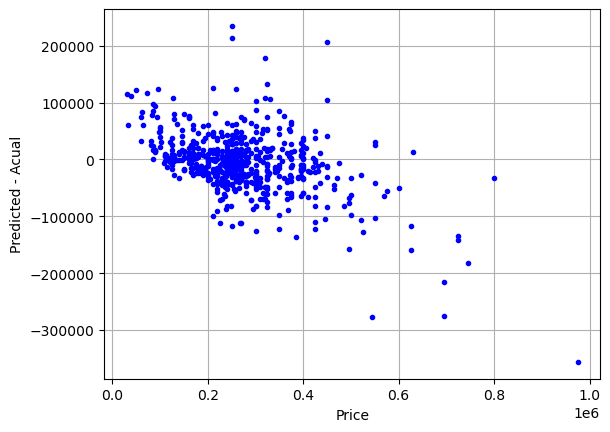

In [16]:
# pick best model and evaluate on training set for now
predict_evaluate(grid_search_lasso_model.best_estimator_, X_train, y_train, True)

### Now try KNN Regressor

In [17]:
# Smaller C = more regularisation
knn_model_param_grid = {'n_neighbors': [k for k in range(1, 51)]}

grid_search_knn_model = GridSearchCV(KNeighborsRegressor(), knn_model_param_grid, cv=5, verbose=3, scoring=rmse)
grid_search_knn_model.fit(X_train, y_train)

print("Best value for k =", grid_search_knn_model.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.38586137966446216
[CV 1/5] END ....................n_neighbors=1;, score=-0.386 total time=   0.1s
RMSE: %2.3f 0.42485555864368546
[CV 2/5] END ....................n_neighbors=1;, score=-0.425 total time=   0.0s
RMSE: %2.3f 0.4198085814173376
[CV 3/5] END ....................n_neighbors=1;, score=-0.420 total time=   0.0s
RMSE: %2.3f 0.4122312785614724
[CV 4/5] END ....................n_neighbors=1;, score=-0.412 total time=   0.0s
RMSE: %2.3f 0.376944099461183
[CV 5/5] END ....................n_neighbors=1;, score=-0.377 total time=   0.0s
RMSE: %2.3f 0.3305510087762619
[CV 1/5] END ....................n_neighbors=2;, score=-0.331 total time=   0.0s
RMSE: %2.3f 0.40313799315398985
[CV 2/5] END ....................n_neighbors=2;, score=-0.403 total time=   0.0s
RMSE: %2.3f 0.37054498835624144
[CV 3/5] END ....................n_neighbors=2;, score=-0.371 total time=   0.0s
RMSE: %2.3f 0.3442790543676485
[CV 4/5]

RMSE: %2.3f 0.3299209450472438
[CV 5/5] END ...................n_neighbors=16;, score=-0.330 total time=   0.0s
RMSE: %2.3f 0.319348485166047
[CV 1/5] END ...................n_neighbors=17;, score=-0.319 total time=   0.0s
RMSE: %2.3f 0.37555736145980395
[CV 2/5] END ...................n_neighbors=17;, score=-0.376 total time=   0.0s
RMSE: %2.3f 0.3078278224299483
[CV 3/5] END ...................n_neighbors=17;, score=-0.308 total time=   0.0s
RMSE: %2.3f 0.34742121792480823
[CV 4/5] END ...................n_neighbors=17;, score=-0.347 total time=   0.0s
RMSE: %2.3f 0.33250318003212376
[CV 5/5] END ...................n_neighbors=17;, score=-0.333 total time=   0.0s
RMSE: %2.3f 0.32429366501283424
[CV 1/5] END ...................n_neighbors=18;, score=-0.324 total time=   0.0s
RMSE: %2.3f 0.37705354325467355
[CV 2/5] END ...................n_neighbors=18;, score=-0.377 total time=   0.0s
RMSE: %2.3f 0.30838517799893683
[CV 3/5] END ...................n_neighbors=18;, score=-0.308 total 

RMSE: %2.3f 0.36414495755628995
[CV 4/5] END ...................n_neighbors=34;, score=-0.364 total time=   0.0s
RMSE: %2.3f 0.3388917529184202
[CV 5/5] END ...................n_neighbors=34;, score=-0.339 total time=   0.0s
RMSE: %2.3f 0.3466577045702885
[CV 1/5] END ...................n_neighbors=35;, score=-0.347 total time=   0.0s
RMSE: %2.3f 0.3827857247798438
[CV 2/5] END ...................n_neighbors=35;, score=-0.383 total time=   0.0s
RMSE: %2.3f 0.31255755740035246
[CV 3/5] END ...................n_neighbors=35;, score=-0.313 total time=   0.0s
RMSE: %2.3f 0.3650960547047636
[CV 4/5] END ...................n_neighbors=35;, score=-0.365 total time=   0.0s
RMSE: %2.3f 0.33839313831299184
[CV 5/5] END ...................n_neighbors=35;, score=-0.338 total time=   0.0s
RMSE: %2.3f 0.34692898382532383
[CV 1/5] END ...................n_neighbors=36;, score=-0.347 total time=   0.0s
RMSE: %2.3f 0.3816047748717885
[CV 2/5] END ...................n_neighbors=36;, score=-0.382 total t

RSME = 60707.80166837283


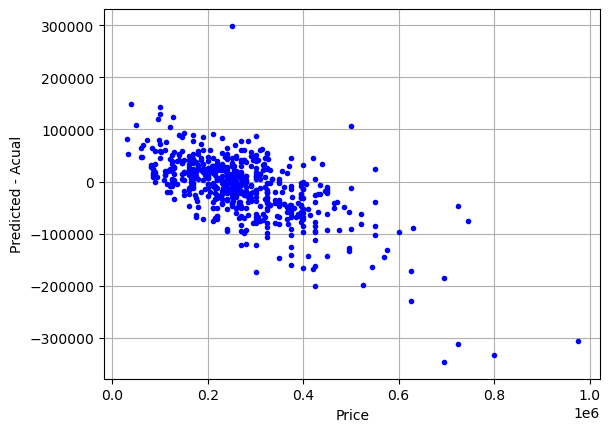

In [18]:
# evaluate
predict_evaluate(grid_search_knn_model.best_estimator_, X_train, y_train, True)

### Now try Support Vector Regressor

In [19]:
svr_param_search = {
    'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 4, 8], 
    'gamma': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 4, 8], 
    'kernel': ['rbf', 'poly']}

random_search_svr_model = RandomizedSearchCV(SVR(), svr_param_search, n_iter=50, cv=5, verbose=3, scoring=rmse, random_state=101)
random_search_svr_model.fit(X_train, y_train)

print("Best hyperparameters for SVR =", random_search_svr_model.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.4119467784405359
[CV 1/5] END ...C=0.5, gamma=0.01, kernel=poly;, score=-0.412 total time=   0.0s
RMSE: %2.3f 0.44799480932761365
[CV 2/5] END ...C=0.5, gamma=0.01, kernel=poly;, score=-0.448 total time=   0.0s
RMSE: %2.3f 0.33547920821967786
[CV 3/5] END ...C=0.5, gamma=0.01, kernel=poly;, score=-0.335 total time=   0.0s
RMSE: %2.3f 0.3914066357565818
[CV 4/5] END ...C=0.5, gamma=0.01, kernel=poly;, score=-0.391 total time=   0.0s
RMSE: %2.3f 0.4184227504253012
[CV 5/5] END ...C=0.5, gamma=0.01, kernel=poly;, score=-0.418 total time=   0.0s
RMSE: %2.3f 0.30064404147811336
[CV 1/5] END ....C=0.001, gamma=2, kernel=poly;, score=-0.301 total time=   0.0s
RMSE: %2.3f 0.3429595900350962
[CV 2/5] END ....C=0.001, gamma=2, kernel=poly;, score=-0.343 total time=   0.0s
RMSE: %2.3f 0.3512042282124361
[CV 3/5] END ....C=0.001, gamma=2, kernel=poly;, score=-0.351 total time=   0.0s
RMSE: %2.3f 0.39097621096152935
[CV 4/5

RMSE: %2.3f 0.4757376734417415
[CV 5/5] END .......C=0.1, gamma=4, kernel=rbf;, score=-0.476 total time=   0.0s
RMSE: %2.3f 0.4909514468668007
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.491 total time=   0.0s
RMSE: %2.3f 0.49292818231081925
[CV 2/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.493 total time=   0.0s
RMSE: %2.3f 0.38621246681941007
[CV 3/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.386 total time=   0.0s
RMSE: %2.3f 0.44472553958116623
[CV 4/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.445 total time=   0.0s
RMSE: %2.3f 0.47175622102507087
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.472 total time=   0.0s
RMSE: %2.3f 0.4965375268420587
[CV 1/5] END ...C=8, gamma=0.0001, kernel=poly;, score=-0.497 total time=   0.0s
RMSE: %2.3f 0.4963459811865809
[CV 2/5] END ...C=8, gamma=0.0001, kernel=poly;, score=-0.496 total time=   0.0s
RMSE: %2.3f 0.3902053094664981
[CV 3/5] END ...C=8, gamma=0.0001, kernel=poly;, score=-0.390 total t

RMSE: %2.3f 0.4555015074092036
[CV 5/5] END .........C=1, gamma=4, kernel=rbf;, score=-0.456 total time=   0.0s
RMSE: %2.3f 0.30064404147811336
[CV 1/5] END ....C=0.001, gamma=4, kernel=poly;, score=-0.301 total time=   0.0s
RMSE: %2.3f 0.3429595900350962
[CV 2/5] END ....C=0.001, gamma=4, kernel=poly;, score=-0.343 total time=   0.0s
RMSE: %2.3f 0.3512042282124361
[CV 3/5] END ....C=0.001, gamma=4, kernel=poly;, score=-0.351 total time=   0.0s
RMSE: %2.3f 0.39097621096152935
[CV 4/5] END ....C=0.001, gamma=4, kernel=poly;, score=-0.391 total time=   0.0s
RMSE: %2.3f 0.3018665032350672
[CV 5/5] END ....C=0.001, gamma=4, kernel=poly;, score=-0.302 total time=   0.0s
RMSE: %2.3f 0.34213775734491325
[CV 1/5] END ....C=2, gamma=0.0001, kernel=rbf;, score=-0.342 total time=   0.0s
RMSE: %2.3f 0.38391250771551344
[CV 2/5] END ....C=2, gamma=0.0001, kernel=rbf;, score=-0.384 total time=   0.0s
RMSE: %2.3f 0.2912881658813099
[CV 3/5] END ....C=2, gamma=0.0001, kernel=rbf;, score=-0.291 total t

RMSE: %2.3f 0.26132841177041227
[CV 3/5] END .....C=1, gamma=0.001, kernel=rbf;, score=-0.261 total time=   0.0s
RMSE: %2.3f 0.2948336928436976
[CV 4/5] END .....C=1, gamma=0.001, kernel=rbf;, score=-0.295 total time=   0.0s
RMSE: %2.3f 0.29021751537852586
[CV 5/5] END .....C=1, gamma=0.001, kernel=rbf;, score=-0.290 total time=   0.0s
RMSE: %2.3f 0.4937448195255149
[CV 1/5] END .........C=2, gamma=4, kernel=rbf;, score=-0.494 total time=   0.0s
RMSE: %2.3f 0.48395985944689385
[CV 2/5] END .........C=2, gamma=4, kernel=rbf;, score=-0.484 total time=   0.0s
RMSE: %2.3f 0.38479840264083465
[CV 3/5] END .........C=2, gamma=4, kernel=rbf;, score=-0.385 total time=   0.0s
RMSE: %2.3f 0.4537643075640796
[CV 4/5] END .........C=2, gamma=4, kernel=rbf;, score=-0.454 total time=   0.0s
RMSE: %2.3f 0.4536858463340757
[CV 5/5] END .........C=2, gamma=4, kernel=rbf;, score=-0.454 total time=   0.0s
RMSE: %2.3f 0.30064404147811336
[CV 1/5] END ........C=2, gamma=8, kernel=poly;, score=-0.301 total 

RSME = 32165.25053615629


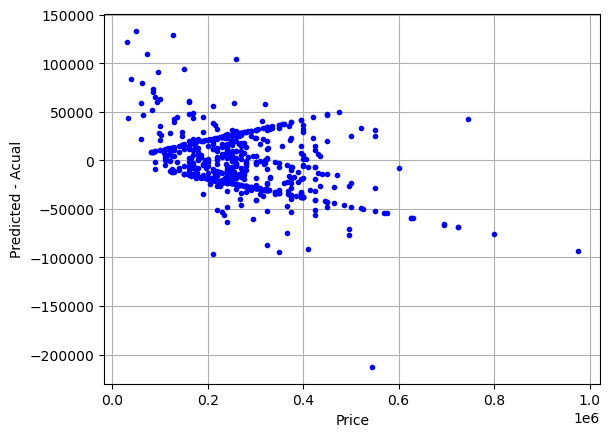

In [20]:
# evaluate
predict_evaluate(random_search_svr_model.best_estimator_, X_train, y_train, True)

### Now try Decision Tree classifier

In [21]:
tree_param_search = {'max_depth': [i for i in range(1, 30)], 'min_samples_split': [i for i in range(2, 30)] }

random_search_tree_model = RandomizedSearchCV(DecisionTreeRegressor(), tree_param_search, n_iter=50,  cv=5, verbose=3, scoring=rmse, random_state=101)
random_search_tree_model.fit(X_train, y_train)

print("Best params =", random_search_tree_model.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.30524562752344003
[CV 1/5] END max_depth=11, min_samples_split=12;, score=-0.305 total time=   0.0s
RMSE: %2.3f 0.3115973014361389
[CV 2/5] END max_depth=11, min_samples_split=12;, score=-0.312 total time=   0.0s
RMSE: %2.3f 0.2696468741777137
[CV 3/5] END max_depth=11, min_samples_split=12;, score=-0.270 total time=   0.0s
RMSE: %2.3f 0.3221392278962825
[CV 4/5] END max_depth=11, min_samples_split=12;, score=-0.322 total time=   0.0s
RMSE: %2.3f 0.2987792888296926
[CV 5/5] END max_depth=11, min_samples_split=12;, score=-0.299 total time=   0.0s
RMSE: %2.3f 0.32860959717971205
[CV 1/5] END max_depth=2, min_samples_split=10;, score=-0.329 total time=   0.0s
RMSE: %2.3f 0.3242560856656799
[CV 2/5] END max_depth=2, min_samples_split=10;, score=-0.324 total time=   0.0s
RMSE: %2.3f 0.2978402177864414
[CV 3/5] END max_depth=2, min_samples_split=10;, score=-0.298 total time=   0.0s
RMSE: %2.3f 0.3549829960769365
[CV 

RMSE: %2.3f 0.2931075181264525
[CV 1/5] END max_depth=6, min_samples_split=13;, score=-0.293 total time=   0.0s
RMSE: %2.3f 0.30506139898010065
[CV 2/5] END max_depth=6, min_samples_split=13;, score=-0.305 total time=   0.0s
RMSE: %2.3f 0.24677436736604588
[CV 3/5] END max_depth=6, min_samples_split=13;, score=-0.247 total time=   0.0s
RMSE: %2.3f 0.3177933433631467
[CV 4/5] END max_depth=6, min_samples_split=13;, score=-0.318 total time=   0.0s
RMSE: %2.3f 0.2952923783648798
[CV 5/5] END max_depth=6, min_samples_split=13;, score=-0.295 total time=   0.0s
RMSE: %2.3f 0.33768175816344514
[CV 1/5] END max_depth=17, min_samples_split=8;, score=-0.338 total time=   0.0s
RMSE: %2.3f 0.3506531506254852
[CV 2/5] END max_depth=17, min_samples_split=8;, score=-0.351 total time=   0.0s
RMSE: %2.3f 0.32823983764907516
[CV 3/5] END max_depth=17, min_samples_split=8;, score=-0.328 total time=   0.0s
RMSE: %2.3f 0.33219970298465795
[CV 4/5] END max_depth=17, min_samples_split=8;, score=-0.332 total 

RMSE: %2.3f 0.29090666779590124
[CV 5/5] END max_depth=22, min_samples_split=19;, score=-0.291 total time=   0.0s
RMSE: %2.3f 0.3051041588413425
[CV 1/5] END max_depth=26, min_samples_split=7;, score=-0.305 total time=   0.0s
RMSE: %2.3f 0.3302013359734743
[CV 2/5] END max_depth=26, min_samples_split=7;, score=-0.330 total time=   0.0s
RMSE: %2.3f 0.2950539399829534
[CV 3/5] END max_depth=26, min_samples_split=7;, score=-0.295 total time=   0.0s
RMSE: %2.3f 0.321424169770059
[CV 4/5] END max_depth=26, min_samples_split=7;, score=-0.321 total time=   0.0s
RMSE: %2.3f 0.32353667452857476
[CV 5/5] END max_depth=26, min_samples_split=7;, score=-0.324 total time=   0.0s
RMSE: %2.3f 0.2932928771163784
[CV 1/5] END max_depth=4, min_samples_split=18;, score=-0.293 total time=   0.0s
RMSE: %2.3f 0.30370835863866547
[CV 2/5] END max_depth=4, min_samples_split=18;, score=-0.304 total time=   0.0s
RMSE: %2.3f 0.2570965546713847
[CV 3/5] END max_depth=4, min_samples_split=18;, score=-0.257 total ti

RMSE: %2.3f 0.27785354612924723
[CV 4/5] END max_depth=7, min_samples_split=28;, score=-0.278 total time=   0.0s
RMSE: %2.3f 0.30864606434640124
[CV 5/5] END max_depth=7, min_samples_split=28;, score=-0.309 total time=   0.0s
RMSE: %2.3f 0.30622979235240133
[CV 1/5] END max_depth=26, min_samples_split=23;, score=-0.306 total time=   0.0s
RMSE: %2.3f 0.32623224796219974
[CV 2/5] END max_depth=26, min_samples_split=23;, score=-0.326 total time=   0.0s
RMSE: %2.3f 0.2545372036765562
[CV 3/5] END max_depth=26, min_samples_split=23;, score=-0.255 total time=   0.0s
RMSE: %2.3f 0.31707361402472317
[CV 4/5] END max_depth=26, min_samples_split=23;, score=-0.317 total time=   0.0s
RMSE: %2.3f 0.306978893324907
[CV 5/5] END max_depth=26, min_samples_split=23;, score=-0.307 total time=   0.0s
RMSE: %2.3f 0.3063029201185544
[CV 1/5] END max_depth=18, min_samples_split=9;, score=-0.306 total time=   0.0s
RMSE: %2.3f 0.3427036303221072
[CV 2/5] END max_depth=18, min_samples_split=9;, score=-0.343 to

RSME = 52736.879331849144


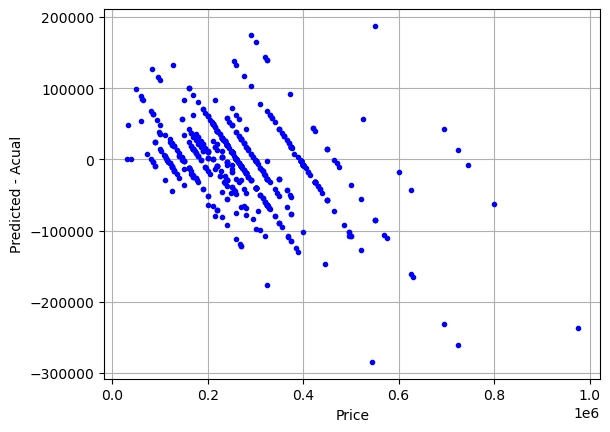

In [22]:
# evaluate
predict_evaluate(random_search_tree_model.best_estimator_, X_train, y_train, True)

Let's look at the best tree. We will fit a decision tree with the best parameters (from the above cross-validation) on the training data and draw the tree

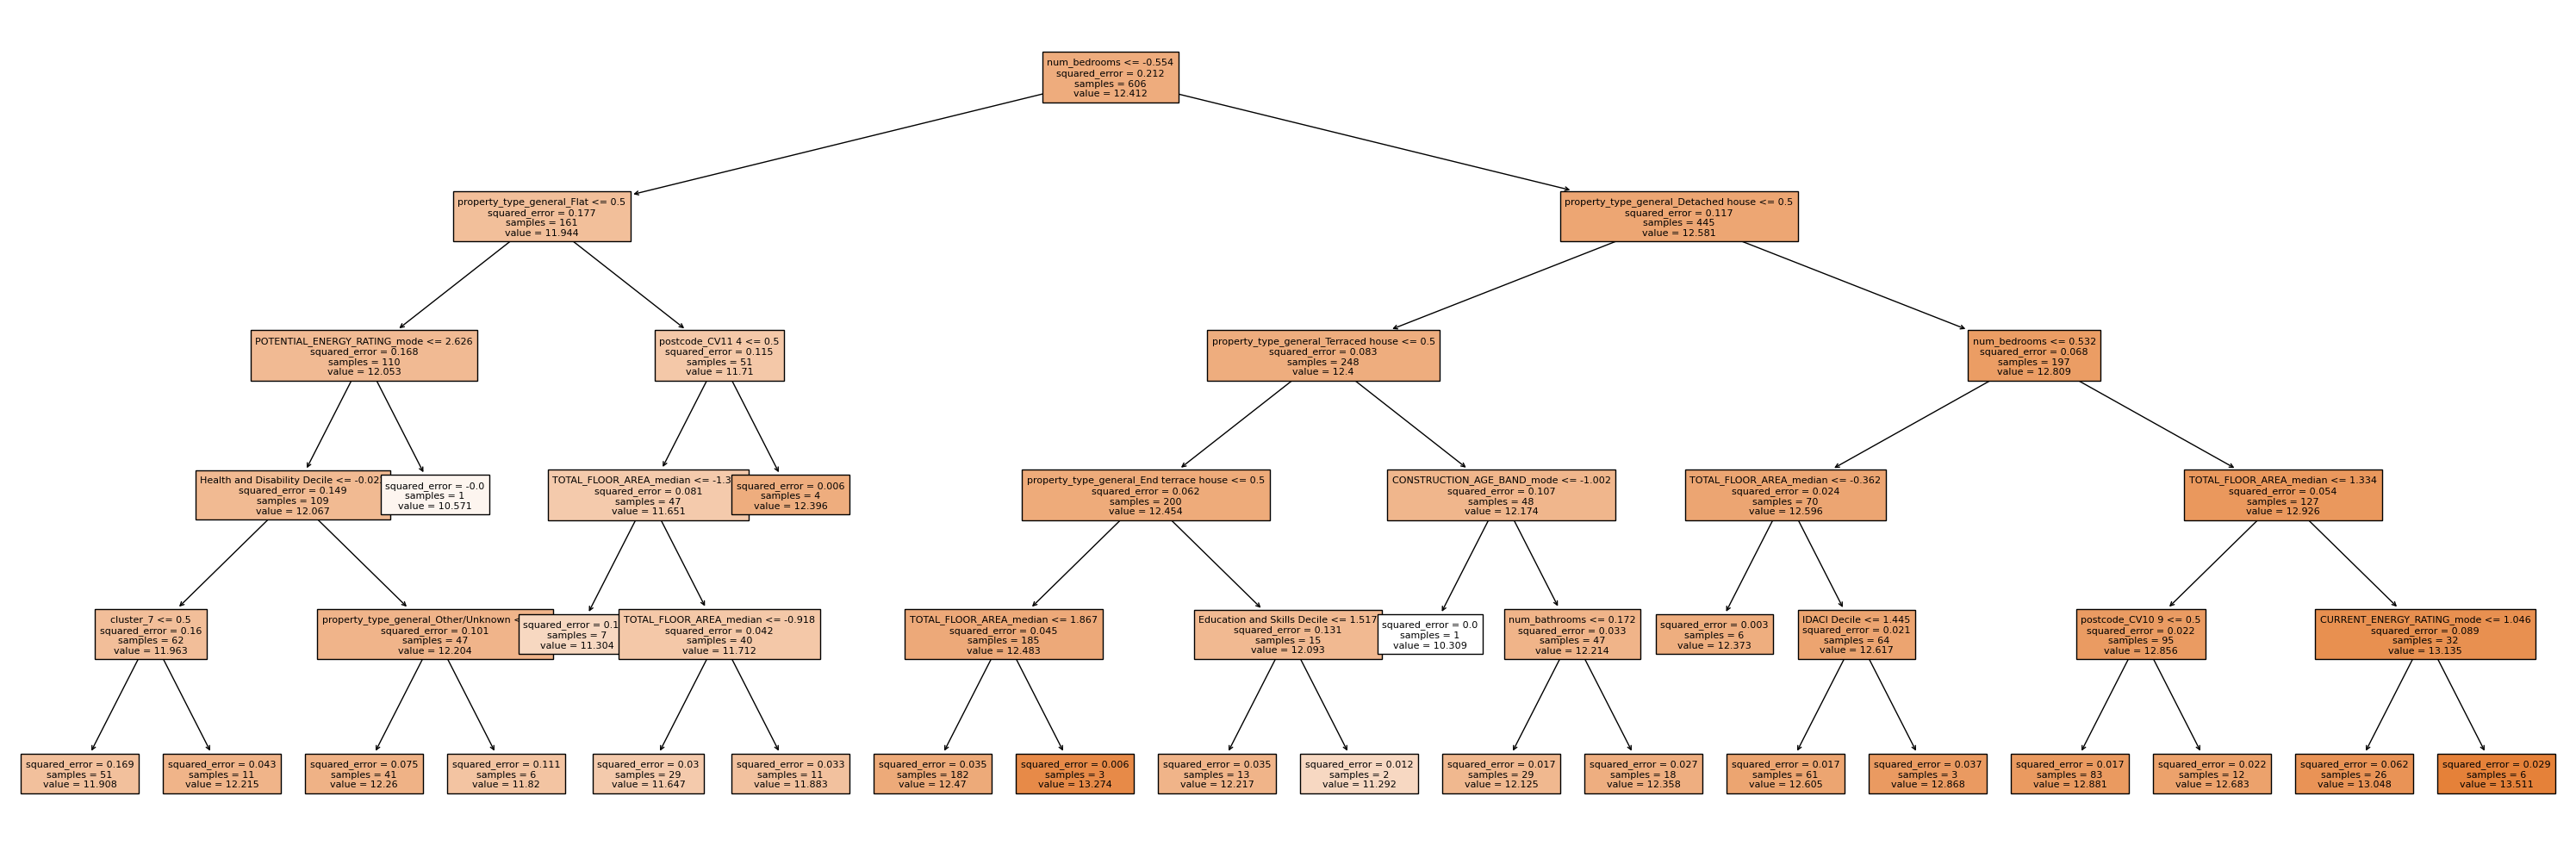

In [23]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 10))
plot_t = plot_tree(random_search_tree_model.best_estimator_, feature_names=X_train.columns, filled=True, fontsize=8)
plt.tight_layout()

### Trees not great on their own. Let's try a Random Forest

In [24]:
forest_param_search = {
    'n_estimators': [i for i in range(50, 300)], 
    'max_depth': [i for i in range(1, 10)], 
    'min_samples_split': [i for i in range(2, 30)]
}

random_search_forest_model = RandomizedSearchCV(RandomForestRegressor(), forest_param_search, n_iter=50, cv=5, verbose=3, scoring=rmse, random_state=101)
random_search_forest_model.fit(X_train, y_train)

print("Best params =", random_search_forest_model.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.26108505302383817
[CV 1/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.261 total time=   0.5s
RMSE: %2.3f 0.2671806819624178
[CV 2/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.267 total time=   0.4s
RMSE: %2.3f 0.25251574963766654
[CV 3/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.253 total time=   0.4s
RMSE: %2.3f 0.2587432160620474
[CV 4/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.259 total time=   0.4s
RMSE: %2.3f 0.2686300527416884
[CV 5/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.269 total time=   0.4s
RMSE: %2.3f 0.2918006137269361
[CV 1/5] END max_depth=3, min_samples_split=17, n_estimators=231;, score=-0.292 total time=   0.3s
RMSE: %2.3f 0.28886796404375786
[CV 2/5] END max_depth=3, min_samples_split=17, n_estimators=231;, score=-0.289 total time=   0.3s
RMSE: %2.3f 0.25751480062

RMSE: %2.3f 0.28232129408702294
[CV 4/5] END max_depth=4, min_samples_split=6, n_estimators=198;, score=-0.282 total time=   0.3s
RMSE: %2.3f 0.2779644236161027
[CV 5/5] END max_depth=4, min_samples_split=6, n_estimators=198;, score=-0.278 total time=   0.3s
RMSE: %2.3f 0.2632388627415975
[CV 1/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.263 total time=   0.4s
RMSE: %2.3f 0.2613217224707551
[CV 2/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.261 total time=   0.4s
RMSE: %2.3f 0.25150532955101973
[CV 3/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.252 total time=   0.4s
RMSE: %2.3f 0.2545377669539646
[CV 4/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.255 total time=   0.4s
RMSE: %2.3f 0.26812448630196845
[CV 5/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.268 total time=   0.4s
RMSE: %2.3f 0.2630751901339157
[CV 1/5] END max_depth=8, min_samples_split=22, n_estimators=23

RMSE: %2.3f 0.24499698472202328
[CV 3/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.245 total time=   0.2s
RMSE: %2.3f 0.28290950037629353
[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.283 total time=   0.2s
RMSE: %2.3f 0.282215898193384
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.282 total time=   0.3s
RMSE: %2.3f 0.25145254658635824
[CV 1/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.251 total time=   0.2s
RMSE: %2.3f 0.27195142856251936
[CV 2/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.272 total time=   0.2s
RMSE: %2.3f 0.2490658972472915
[CV 3/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.249 total time=   0.2s
RMSE: %2.3f 0.2607752350030598
[CV 4/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.261 total time=   0.2s
RMSE: %2.3f 0.26677896549543617
[CV 5/5] END max_depth=9, min_samples_split=16, n_estimator

RMSE: %2.3f 0.28852646743160204
[CV 1/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.289 total time=   0.3s
RMSE: %2.3f 0.289965897535951
[CV 2/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.290 total time=   0.3s
RMSE: %2.3f 0.2534631475286345
[CV 3/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.253 total time=   0.3s
RMSE: %2.3f 0.2992863797357939
[CV 4/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.299 total time=   0.3s
RMSE: %2.3f 0.2938844559235973
[CV 5/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.294 total time=   0.3s
RMSE: %2.3f 0.291254349599918
[CV 1/5] END max_depth=3, min_samples_split=26, n_estimators=241;, score=-0.291 total time=   0.3s
RMSE: %2.3f 0.29117736374894027
[CV 2/5] END max_depth=3, min_samples_split=26, n_estimators=241;, score=-0.291 total time=   0.3s
RMSE: %2.3f 0.2537670888726067
[CV 3/5] END max_depth=3, min_samples_split=26, n_estimators=241

RSME = 28028.51806352918


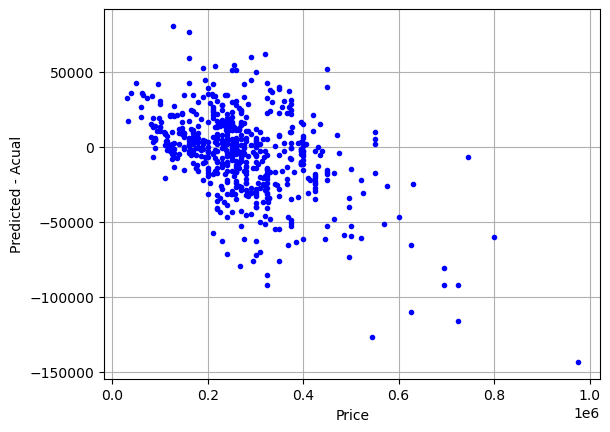

In [25]:
# evaluate
predict_evaluate(random_search_forest_model.best_estimator_, X_train, y_train, True)

Plot feature importances

In [26]:
random_search_forest_model.best_estimator_.feature_importances_

array([8.10337326e-02, 8.50292381e-03, 2.60064631e-03, 2.44633609e-03,
       5.77035283e-03, 1.90115591e-03, 1.69277213e-03, 3.67218109e-05,
       4.44549325e-03, 4.38041554e-01, 2.41190693e-02, 1.24723697e-02,
       1.95537775e-02, 3.23336099e-02, 1.10000365e-02, 8.48664660e-03,
       6.48309732e-03, 1.68970432e-02, 1.26827848e-02, 8.31172762e-03,
       7.48564826e-03, 1.31370336e-02, 8.50028777e-03, 1.14517895e-02,
       1.20788109e-03, 7.15939120e-03, 6.92267365e-04, 1.29205915e-02,
       5.11525548e-04, 7.01244986e-04, 1.83077449e-03, 1.72362346e-04,
       4.76328038e-04, 6.30258325e-04, 4.15587142e-04, 4.34073165e-03,
       3.22109592e-03, 2.57512284e-03, 1.39355443e-03, 5.14975348e-04,
       5.61252522e-05, 2.77655568e-05, 1.07233014e-04, 0.00000000e+00,
       2.02352077e-03, 1.31213831e-03, 1.29445749e-04, 1.23071928e-03,
       4.29326155e-06, 1.84890919e-04, 2.06300028e-04, 1.38470964e-01,
       1.54318401e-02, 1.85459381e-02, 2.74753589e-03, 8.31075971e-03,
      

In [27]:
importances = pd.Series(data=random_search_forest_model.best_estimator_.feature_importances_,
                            index=X_train.columns)

In [28]:
importances = importances.sort_values(ascending=True)

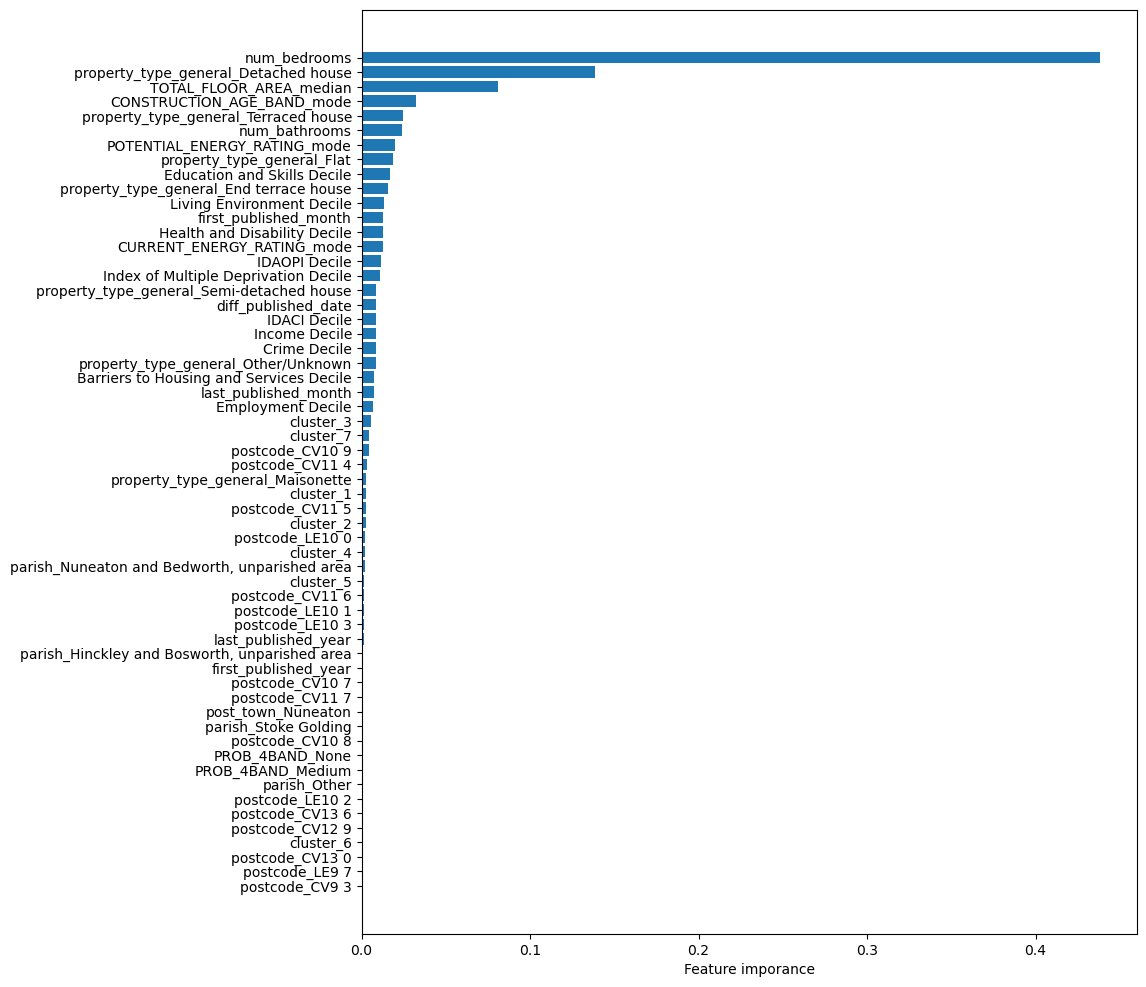

In [29]:
plt.figure(figsize=(10, 12))
plt.barh(range(len(importances)), importances.values)
plt.yticks(range(len(importances)), importances.index);
plt.xlabel('Feature imporance')
plt.show()

### Re-evaluate random forest on most important features

In [30]:
new_cols = importances.index[-30:]

new_random_search_forest_model = RandomizedSearchCV(RandomForestRegressor(), forest_param_search, n_iter=50, cv=5, verbose=3, scoring=rmse, random_state=101)
new_random_search_forest_model.fit(X_train[new_cols], y_train)

print("Best params =", new_random_search_forest_model.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.25930750486134574
[CV 1/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.259 total time=   0.4s
RMSE: %2.3f 0.26808171069236936
[CV 2/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.268 total time=   0.4s
RMSE: %2.3f 0.2513116644647496
[CV 3/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.251 total time=   0.4s
RMSE: %2.3f 0.26429443296849126
[CV 4/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.264 total time=   0.4s
RMSE: %2.3f 0.26945615707920556
[CV 5/5] END max_depth=7, min_samples_split=17, n_estimators=219;, score=-0.269 total time=   0.4s
RMSE: %2.3f 0.29228580768607826
[CV 1/5] END max_depth=3, min_samples_split=17, n_estimators=231;, score=-0.292 total time=   0.3s
RMSE: %2.3f 0.2901588924588177
[CV 2/5] END max_depth=3, min_samples_split=17, n_estimators=231;, score=-0.290 total time=   0.3s
RMSE: %2.3f 0.252618810

RMSE: %2.3f 0.28338145948081245
[CV 4/5] END max_depth=4, min_samples_split=6, n_estimators=198;, score=-0.283 total time=   0.3s
RMSE: %2.3f 0.2753192128659665
[CV 5/5] END max_depth=4, min_samples_split=6, n_estimators=198;, score=-0.275 total time=   0.3s
RMSE: %2.3f 0.2580263105986525
[CV 1/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.258 total time=   0.3s
RMSE: %2.3f 0.2681889533236725
[CV 2/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.268 total time=   0.3s
RMSE: %2.3f 0.25462485971707494
[CV 3/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.255 total time=   0.3s
RMSE: %2.3f 0.2594256647181851
[CV 4/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.259 total time=   0.4s
RMSE: %2.3f 0.2685662951979897
[CV 5/5] END max_depth=6, min_samples_split=3, n_estimators=191;, score=-0.269 total time=   0.3s
RMSE: %2.3f 0.26337276982968305
[CV 1/5] END max_depth=8, min_samples_split=22, n_estimators=23

RMSE: %2.3f 0.2802084327087928
[CV 2/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.280 total time=   0.2s
RMSE: %2.3f 0.24484045008297853
[CV 3/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.245 total time=   0.2s
RMSE: %2.3f 0.2825046345709506
[CV 4/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.283 total time=   0.2s
RMSE: %2.3f 0.281360942737624
[CV 5/5] END max_depth=4, min_samples_split=22, n_estimators=156;, score=-0.281 total time=   0.2s
RMSE: %2.3f 0.2519421867864732
[CV 1/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.252 total time=   0.2s
RMSE: %2.3f 0.2672643207316172
[CV 2/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.267 total time=   0.1s
RMSE: %2.3f 0.25727549422651796
[CV 3/5] END max_depth=9, min_samples_split=16, n_estimators=78;, score=-0.257 total time=   0.1s
RMSE: %2.3f 0.251831055069779
[CV 4/5] END max_depth=9, min_samples_split=16, n_estimators=7

RMSE: %2.3f 0.2916515195345397
[CV 1/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.292 total time=   0.3s
RMSE: %2.3f 0.2898711482665867
[CV 2/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.290 total time=   0.3s
RMSE: %2.3f 0.24819988717831984
[CV 3/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.248 total time=   0.3s
RMSE: %2.3f 0.30131616935950356
[CV 4/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.301 total time=   0.3s
RMSE: %2.3f 0.2935109572366228
[CV 5/5] END max_depth=3, min_samples_split=7, n_estimators=236;, score=-0.294 total time=   0.3s
RMSE: %2.3f 0.2918900230844729
[CV 1/5] END max_depth=3, min_samples_split=26, n_estimators=241;, score=-0.292 total time=   0.3s
RMSE: %2.3f 0.2900601133745636
[CV 2/5] END max_depth=3, min_samples_split=26, n_estimators=241;, score=-0.290 total time=   0.3s
RMSE: %2.3f 0.2513027700489574
[CV 3/5] END max_depth=3, min_samples_split=26, n_estimators=2

RSME = 28496.70970925979


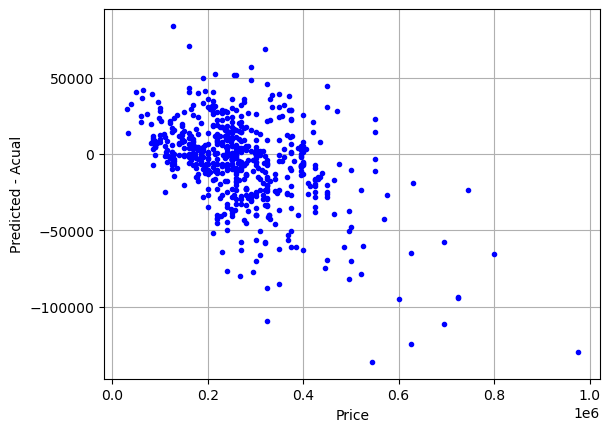

In [31]:
# evaluate
predict_evaluate(new_random_search_forest_model.best_estimator_, X_train[new_cols], y_train, True)

Performs very similarly but not quite as well as expected

### Try performing PCA on the features

In [32]:
random_forest_pca_pipeline = Pipeline([
    ('pca', PCA()),
    ('rforest', RandomForestRegressor())
])

forest_param_search_2 = {
    'pca__n_components': [i for i in range(1, len(X_train.columns))],
    'rforest__n_estimators': [i for i in range(50, 300)], 
    'rforest__max_depth': [i for i in range(1, 10)], 
    'rforest__min_samples_split': [i for i in range(2, 30)]
}


random_search_forest_model_with_pca = RandomizedSearchCV(random_forest_pca_pipeline, forest_param_search_2, n_iter=50, cv=5, verbose=3, scoring=rmse, random_state=101)
random_search_forest_model_with_pca.fit(X_train, y_train)

print("Best params =", random_search_forest_model_with_pca.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: %2.3f 0.29653905783814616
[CV 1/5] END pca__n_components=53, rforest__max_depth=7, rforest__min_samples_split=20, rforest__n_estimators=269;, score=-0.297 total time=   2.0s
RMSE: %2.3f 0.31398341028297205
[CV 2/5] END pca__n_components=53, rforest__max_depth=7, rforest__min_samples_split=20, rforest__n_estimators=269;, score=-0.314 total time=   1.9s
RMSE: %2.3f 0.2643863556528394
[CV 3/5] END pca__n_components=53, rforest__max_depth=7, rforest__min_samples_split=20, rforest__n_estimators=269;, score=-0.264 total time=   1.9s
RMSE: %2.3f 0.2823353794678025
[CV 4/5] END pca__n_components=53, rforest__max_depth=7, rforest__min_samples_split=20, rforest__n_estimators=269;, score=-0.282 total time=   1.9s
RMSE: %2.3f 0.2993509248040188
[CV 5/5] END pca__n_components=53, rforest__max_depth=7, rforest__min_samples_split=20, rforest__n_estimators=269;, score=-0.299 total time=   1.9s
RMSE: %2.3f 0.3298733902894511
[CV 1/5] E

RMSE: %2.3f 0.438162904069523
[CV 2/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=20, rforest__n_estimators=254;, score=-0.438 total time=   0.5s
RMSE: %2.3f 0.3359967350233371
[CV 3/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=20, rforest__n_estimators=254;, score=-0.336 total time=   0.5s
RMSE: %2.3f 0.3952235172580385
[CV 4/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=20, rforest__n_estimators=254;, score=-0.395 total time=   0.5s
RMSE: %2.3f 0.41954532937903677
[CV 5/5] END pca__n_components=20, rforest__max_depth=1, rforest__min_samples_split=20, rforest__n_estimators=254;, score=-0.420 total time=   0.5s
RMSE: %2.3f 0.35548557170457645
[CV 1/5] END pca__n_components=23, rforest__max_depth=2, rforest__min_samples_split=23, rforest__n_estimators=204;, score=-0.355 total time=   0.5s
RMSE: %2.3f 0.393931130291777
[CV 2/5] END pca__n_components=23, rforest__max_depth=2, rforest__min_samp

RMSE: %2.3f 0.3106171434321607
[CV 3/5] END pca__n_components=34, rforest__max_depth=2, rforest__min_samples_split=17, rforest__n_estimators=168;, score=-0.311 total time=   0.5s
RMSE: %2.3f 0.3612990611101652
[CV 4/5] END pca__n_components=34, rforest__max_depth=2, rforest__min_samples_split=17, rforest__n_estimators=168;, score=-0.361 total time=   0.5s
RMSE: %2.3f 0.3525194562653202
[CV 5/5] END pca__n_components=34, rforest__max_depth=2, rforest__min_samples_split=17, rforest__n_estimators=168;, score=-0.353 total time=   0.5s
RMSE: %2.3f 0.29524807572794093
[CV 1/5] END pca__n_components=39, rforest__max_depth=8, rforest__min_samples_split=13, rforest__n_estimators=89;, score=-0.295 total time=   0.7s
RMSE: %2.3f 0.29751061354223374
[CV 2/5] END pca__n_components=39, rforest__max_depth=8, rforest__min_samples_split=13, rforest__n_estimators=89;, score=-0.298 total time=   0.7s
RMSE: %2.3f 0.26198578464609446
[CV 3/5] END pca__n_components=39, rforest__max_depth=8, rforest__min_sam

RMSE: %2.3f 0.28689555849572457
[CV 4/5] END pca__n_components=14, rforest__max_depth=8, rforest__min_samples_split=15, rforest__n_estimators=83;, score=-0.287 total time=   0.4s
RMSE: %2.3f 0.29524881280692766
[CV 5/5] END pca__n_components=14, rforest__max_depth=8, rforest__min_samples_split=15, rforest__n_estimators=83;, score=-0.295 total time=   0.4s
RMSE: %2.3f 0.3051328936261697
[CV 1/5] END pca__n_components=38, rforest__max_depth=7, rforest__min_samples_split=21, rforest__n_estimators=87;, score=-0.305 total time=   0.6s
RMSE: %2.3f 0.3030348216845075
[CV 2/5] END pca__n_components=38, rforest__max_depth=7, rforest__min_samples_split=21, rforest__n_estimators=87;, score=-0.303 total time=   0.6s
RMSE: %2.3f 0.26970412649366904
[CV 3/5] END pca__n_components=38, rforest__max_depth=7, rforest__min_samples_split=21, rforest__n_estimators=87;, score=-0.270 total time=   0.6s
RMSE: %2.3f 0.27753165326031487
[CV 4/5] END pca__n_components=38, rforest__max_depth=7, rforest__min_sampl

RMSE: %2.3f 0.29456809113853344
[CV 5/5] END pca__n_components=20, rforest__max_depth=7, rforest__min_samples_split=16, rforest__n_estimators=281;, score=-0.295 total time=   1.0s
RMSE: %2.3f 0.35298305083654813
[CV 1/5] END pca__n_components=56, rforest__max_depth=3, rforest__min_samples_split=13, rforest__n_estimators=243;, score=-0.353 total time=   1.1s
RMSE: %2.3f 0.3521728783409051
[CV 2/5] END pca__n_components=56, rforest__max_depth=3, rforest__min_samples_split=13, rforest__n_estimators=243;, score=-0.352 total time=   1.1s
RMSE: %2.3f 0.29063053772513897
[CV 3/5] END pca__n_components=56, rforest__max_depth=3, rforest__min_samples_split=13, rforest__n_estimators=243;, score=-0.291 total time=   1.2s
RMSE: %2.3f 0.33470682900285026
[CV 4/5] END pca__n_components=56, rforest__max_depth=3, rforest__min_samples_split=13, rforest__n_estimators=243;, score=-0.335 total time=   1.2s
RMSE: %2.3f 0.32963171386344425
[CV 5/5] END pca__n_components=56, rforest__max_depth=3, rforest__min

RMSE: %2.3f 0.30344288273007214
[CV 1/5] END pca__n_components=11, rforest__max_depth=7, rforest__min_samples_split=21, rforest__n_estimators=119;, score=-0.303 total time=   0.4s
RMSE: %2.3f 0.33963473438233077
[CV 2/5] END pca__n_components=11, rforest__max_depth=7, rforest__min_samples_split=21, rforest__n_estimators=119;, score=-0.340 total time=   0.4s
RMSE: %2.3f 0.2933490664065572
[CV 3/5] END pca__n_components=11, rforest__max_depth=7, rforest__min_samples_split=21, rforest__n_estimators=119;, score=-0.293 total time=   0.4s
RMSE: %2.3f 0.3143343969390247
[CV 4/5] END pca__n_components=11, rforest__max_depth=7, rforest__min_samples_split=21, rforest__n_estimators=119;, score=-0.314 total time=   0.4s
RMSE: %2.3f 0.30281966220085094
[CV 5/5] END pca__n_components=11, rforest__max_depth=7, rforest__min_samples_split=21, rforest__n_estimators=119;, score=-0.303 total time=   0.4s
RMSE: %2.3f 0.29814774907156727
[CV 1/5] END pca__n_components=31, rforest__max_depth=9, rforest__min_

RSME = 43983.80253323988


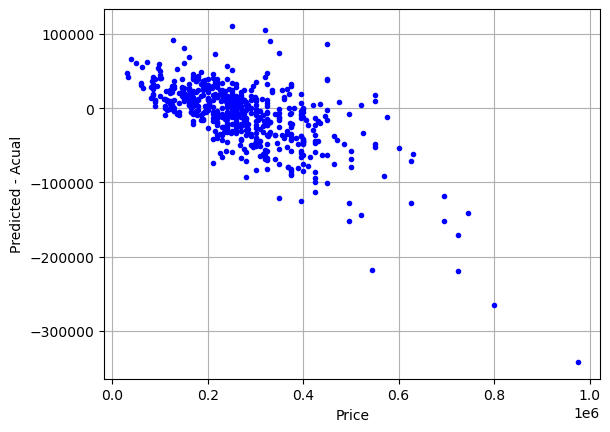

In [33]:
# evaluate
predict_evaluate(random_search_forest_model_with_pca.best_estimator_, X_train, y_train, True)

### Evaluate best model on test data
The random forest proved to be the best estimator in training. Let's see how this fares on the test data

In [34]:
best_model = random_search_forest_model_with_pca.best_estimator_

RSME = 63584.36625360697


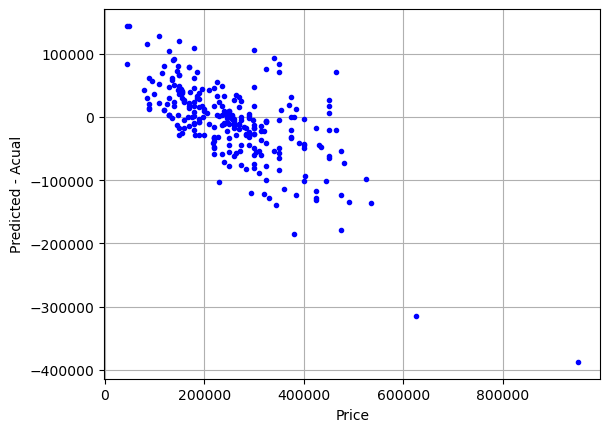

In [35]:
predict_evaluate(best_model, X_test, y_test, True)

### Final words

The overall test result is a bit worse than for the training data, which is expected. With an RMSE of ~£60,000, the model could be use to get a baseline estimate for the house asking price, but not an accurate score. Improvements could be made by adding in more features (through knowing the exact address of the house), adding more data points, or trying more models.